## Task e)  Image Retrieval on COCO with Faster R-CNN or Mask R-CNN

### Import required libraries

In [14]:
import glob
from itertools import chain
import os
import random
import zipfile
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, ops
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import json

### Dataset and data loader

In [15]:
PATH_TRAIN = "./COCO/train2014/"
PATH_VALID = "./COCO/val2014/"
ANNOTATIONS = "./COCO/mcv_image_retrieval_annotations.json"
from typing import Any, Callable, List, Optional, Tuple
import copy
from PIL import Image

class TripletData(datasets.VisionDataset):
    
    def __init__(self, root: str, annFile: str, annotationsTrain: str, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, transforms: Optional[Callable] = None, train=True) -> None:
        super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO
        self.data = None
        self.train = train
        if self.train == True:
            self.data = 'train'
        else:
            self.data = 'val'

        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

        self.image_categories = {}
        self.categories = []
        self.contents = None

         # load JSON data into a dictionary
        with open(annotationsTrain, 'r') as j:
            self.contents = json.loads(j.read())
        for category in self.contents[self.data]:
            self.categories.append(str(category))


        for category in self.contents[self.data]:
            for image_id in self.contents[self.data][str(category)]:
                if str(image_id) not in self.image_categories:
                    self.image_categories[str(image_id)] = []
                self.image_categories[str(image_id)].append(str(category))

        # get the keys of the dictionary
        keys = list(self.image_categories.keys())

        # create a dictionary that maps a number starting from 0 to a key
        self.mapped_keys = {i: key for i, key in enumerate(keys)}

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return path

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def _fix_target(self, target1: dict) -> dict:
        boxes = []
        labels = []

        for object in target1:
            boxes.append(object['bbox'])
            labels.append(object['category_id'])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        boxes = torch.squeeze(boxes)
        boxes = ops.box_convert(boxes, 'xywh', 'xyxy')
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target_im1 = {}
        target_im1['boxes'] = boxes
        target_im1['labels'] = labels

        return target_im1
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        index = self.mapped_keys[index]
        # pick a random object from the different objects inside the image
        category = random.choice(self.image_categories[str(index)])
        
        # choosing our pair of positive images (im1, im2)
        im1 = index
        im2 = random.choice(self.contents[self.data][str(category)])
        while im2 == im1:
            im2 = random.choice(self.contents[self.data][str(category)])
            
        # choosing a negative class and negative image (im3)
        negative_cats = copy.deepcopy(self.categories)
        for i in self.image_categories[str(im1)]:
            if i in negative_cats:
                negative_cats.remove(str(i))
                
        for i in self.image_categories[str(im2)]:
            if i in negative_cats:
                negative_cats.remove(str(i))
                
        negative_cat = str(random.choice(negative_cats))
        
        im3 = random.choice(self.contents[self.data][negative_cat])
        filename_im1, filename_im2, filename_im3  = self._load_image(int(im1)), self._load_image(int(im2)), self._load_image(int(im3))
        
        im1,im2,im3 = os.path.join(self.root, filename_im1), os.path.join(self.root, filename_im2), os.path.join(self.root, filename_im3)
        im1,im2,im3 = Image.open(im1).convert('RGB') , Image.open(im2).convert('RGB') , Image.open(im3).convert('RGB')
 

        if self.transform is not None:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            im3 = self.transform(im3)

        return (im1, im2, im3)


    def __len__(self) -> int: #FIX THIS SHIT
        return len(self.image_categories) - 1


# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

def collate_fn(batch):
    #print(batch)
    return tuple(zip(*batch))



In [18]:
# Datasets and Dataloaders
train_data = TripletData(PATH_TRAIN,'./COCO/instances_train2014.json', annotationsTrain=ANNOTATIONS, transform=train_transforms)
val_data = TripletData(PATH_VALID, './COCO/instances_val2014.json', annotationsTrain=ANNOTATIONS, transform=val_transforms, train=False)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle=True, num_workers=0) # ''' collate_fn=collate_fn'''
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=32, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=11.23s)
creating index...
index created!
loading annotations into memory...
Done (t=6.14s)
creating index...
index created!


### Triplet loss and training pipeline

In [19]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    # Distances in embedding space is calculated in euclidean
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()
      
epochs = 3
device = 'cuda'

# Our base model
#model = models.resnet18().cuda()
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).backbone.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
triplet_loss = TripletLoss(margin=0.5)

# Training
for epoch in range(epochs):
    model.train()
  
    epoch_loss = 0.0
    index = 0
    for data in tqdm(train_loader):
        #print(data)
        optimizer.zero_grad()
       # print(data)
        x1,x2,x3 = data
        e1 = model(x1.to(device))
        e2 = model(x2.to(device))
        e3 = model(x3.to(device)) 
        loss = triplet_loss(e1["0"],e2["0"],e3["0"])
        index += 1
        epoch_loss += loss
        print("Batch Loss: {}".format(epoch_loss.item() / index))
        loss.backward()
        optimizer.step()
    print("Train Loss: {}".format(epoch_loss.item() / index))

    index = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in tqdm(val_loader):
            print(data)
            x1,x2,x3 = data
            e1 = model(x1.to(device))
            e2 = model(x2.to(device))
            e3 = model(x3.to(device)) 
            loss = triplet_loss(e1["0"],e2["0"],e3["0"])
            index += 1
            val_loss += loss
    print("Val Loss: {}".format(val_loss.item() / index))
  




   

  0%|          | 0/37 [00:00<?, ?it/s]

[tensor([[[[-2.3515e+00, -2.3515e+00, -2.3515e+00,  ..., -3.3549e-01,
           -4.3242e-01, -4.3242e-01],
          [-2.3515e+00, -2.3709e+00, -2.3709e+00,  ..., -2.9672e-01,
           -3.7426e-01, -3.9365e-01],
          [-2.3321e+00, -2.3515e+00, -2.3709e+00,  ..., -3.9365e-01,
           -4.1303e-01, -4.3242e-01],
          ...,
          [ 1.4285e+00,  1.4479e+00,  1.5061e+00,  ...,  3.8175e-01,
            3.0421e-01,  2.4605e-01],
          [ 1.3704e+00,  1.4285e+00,  1.5255e+00,  ...,  3.0421e-01,
            2.0728e-01,  1.6851e-01],
          [ 1.3510e+00,  1.4091e+00,  1.5061e+00,  ...,  2.6544e-01,
            2.0728e-01,  1.8790e-01]],

         [[-1.6119e+00, -1.5922e+00, -1.5726e+00,  ...,  5.3177e-01,
            4.9244e-01,  4.3344e-01],
          [-1.5726e+00, -1.5726e+00, -1.5332e+00,  ...,  5.3177e-01,
            4.7277e-01,  4.5310e-01],
          [-1.5726e+00, -1.5529e+00, -1.5332e+00,  ...,  5.7111e-01,
            5.1211e-01,  4.7277e-01],
          ...,
    

  0%|          | 0/2565 [00:00<?, ?it/s]

Batch Loss: 59.2685546875
Batch Loss: 56.31178665161133
Batch Loss: 49.79344685872396
Batch Loss: 48.401363372802734
Batch Loss: 47.791717529296875
Batch Loss: 45.95885721842448
Batch Loss: 45.81769234793527
Batch Loss: 45.32200241088867
Batch Loss: 43.81327650282118
Batch Loss: 42.865673828125
Batch Loss: 42.16775235262784
Batch Loss: 41.00027211507162
Batch Loss: 40.2459951547476
Batch Loss: 39.50419398716518
Batch Loss: 38.5193359375
Batch Loss: 38.34619903564453
Batch Loss: 37.727302102481616
Batch Loss: 37.26896837022569
Batch Loss: 36.459321674547695
Batch Loss: 35.95655822753906
Batch Loss: 35.188685825892854
Batch Loss: 34.490692138671875
Batch Loss: 33.9490674889606
Batch Loss: 33.25526682535807
Batch Loss: 32.86712158203125
Batch Loss: 32.247579721304085
Batch Loss: 31.787061903211807
Batch Loss: 31.31512451171875
Batch Loss: 30.797201222386853
Batch Loss: 30.355521647135415
Batch Loss: 29.90384994014617
Batch Loss: 29.582714080810547
Batch Loss: 29.122416178385418
Batch Loss

  0%|          | 0/37 [00:00<?, ?it/s]

[tensor([[[[-1.7118e+00, -1.6924e+00, -1.6731e+00,  ..., -1.3823e+00,
           -1.4211e+00, -1.4404e+00],
          [-1.7118e+00, -1.6731e+00, -1.6731e+00,  ..., -1.3629e+00,
           -1.4017e+00, -1.4404e+00],
          [-1.6924e+00, -1.6924e+00, -1.6924e+00,  ..., -1.3629e+00,
           -1.4017e+00, -1.4211e+00],
          ...,
          [-1.5761e+00, -1.5567e+00, -1.5567e+00,  ..., -1.8281e+00,
           -1.8281e+00, -1.8087e+00],
          [-1.5567e+00, -1.5374e+00, -1.5374e+00,  ..., -1.8281e+00,
           -1.8475e+00, -1.8281e+00],
          [-1.5567e+00, -1.5567e+00, -1.5374e+00,  ..., -1.8087e+00,
           -1.8281e+00, -1.8669e+00]],

         [[-7.2691e-01, -7.2691e-01, -7.2691e-01,  ..., -4.5157e-01,
           -4.9090e-01, -5.1057e-01],
          [-7.2691e-01, -7.2691e-01, -7.2691e-01,  ..., -4.5157e-01,
           -4.9090e-01, -5.1057e-01],
          [-7.0724e-01, -7.0724e-01, -7.0724e-01,  ..., -4.7124e-01,
           -4.7124e-01, -4.9090e-01],
          ...,
    

  0%|          | 0/2565 [00:00<?, ?it/s]

Batch Loss: 0.39454376697540283
Batch Loss: 0.4238961935043335
Batch Loss: 0.42069029808044434
Batch Loss: 0.43253564834594727
Batch Loss: 0.4078709125518799
Batch Loss: 0.40663671493530273
Batch Loss: 0.4001049654824393
Batch Loss: 0.4030165672302246
Batch Loss: 0.39838430616590714
Batch Loss: 0.4032700538635254
Batch Loss: 0.39658203991976654
Batch Loss: 0.3971201578776042
Batch Loss: 0.3909333669222318
Batch Loss: 0.38612362316676546
Batch Loss: 0.3859684626261393
Batch Loss: 0.3851652145385742
Batch Loss: 0.38387135898365693
Batch Loss: 0.3805905448065864
Batch Loss: 0.3893302114386308
Batch Loss: 0.3916118860244751
Batch Loss: 0.38991219656808035
Batch Loss: 0.396438251842152
Batch Loss: 0.39953012051789655
Batch Loss: 0.40109845002492267
Batch Loss: 0.40197654724121096
Batch Loss: 0.4050454359788161
Batch Loss: 0.4043596055772569
Batch Loss: 0.40116807392665316
Batch Loss: 0.4014142135093952
Batch Loss: 0.39905010859171547
Batch Loss: 0.39714800926946825
Batch Loss: 0.39915937185

  0%|          | 0/37 [00:00<?, ?it/s]

[tensor([[[[-2.7734e-01, -2.1919e-01, -2.1919e-01,  ..., -1.2226e-01,
           -1.4165e-01, -1.6103e-01],
          [-1.9980e-01, -1.8042e-01, -2.1919e-01,  ..., -2.5336e-02,
           -4.4721e-02, -8.3491e-02],
          [-2.1919e-01, -1.9980e-01, -2.1919e-01,  ..., -5.9512e-03,
           -2.5336e-02, -6.4106e-02],
          ...,
          [ 1.1036e-01,  7.1589e-02,  7.1589e-02,  ...,  2.8482e-01,
           -1.0288e-01, -1.5955e+00],
          [ 1.1036e-01,  7.1589e-02,  5.2204e-02,  ...,  8.8576e-01,
            3.0421e-01, -1.5761e+00],
          [ 1.4913e-01,  1.1036e-01,  5.2204e-02,  ...,  8.6637e-01,
            1.8790e-01, -1.6343e+00]],

         [[-3.3357e-01, -3.1390e-01, -3.1390e-01,  ..., -1.1723e-01,
           -9.7567e-02, -1.3690e-01],
          [-3.3357e-01, -2.7457e-01, -2.5490e-01,  ..., -7.7900e-02,
           -7.7900e-02, -9.7567e-02],
          [-3.3357e-01, -2.7457e-01, -2.7457e-01,  ...,  7.6703e-04,
           -3.8567e-02, -3.8567e-02],
          ...,
    

  0%|          | 0/2565 [00:00<?, ?it/s]

Batch Loss: 0.4606156647205353
Batch Loss: 0.4336780309677124
Batch Loss: 0.4208064874013265
Batch Loss: 0.40335172414779663
Batch Loss: 0.3849019050598145
Batch Loss: 0.39247143268585205
Batch Loss: 0.3769981179918562
Batch Loss: 0.37048864364624023
Batch Loss: 0.3611723052130805
Batch Loss: 0.36304264068603515
Batch Loss: 0.36220541867342865
Batch Loss: 0.35874974727630615
Batch Loss: 0.36487318919255185
Batch Loss: 0.36865765707833426
Batch Loss: 0.36301279067993164
Batch Loss: 0.3583166003227234
Batch Loss: 0.35572301640230064
Batch Loss: 0.35622207323710126
Batch Loss: 0.3549100725274337
Batch Loss: 0.3538095951080322
Batch Loss: 0.34672521409534274
Batch Loss: 0.3487371097911488
Batch Loss: 0.3528774095618207
Batch Loss: 0.35137295722961426
Batch Loss: 0.35448982238769533
Batch Loss: 0.3603132688082181
Batch Loss: 0.3602585969147859
Batch Loss: 0.3629035949707031
Batch Loss: 0.3618681348603347
Batch Loss: 0.3600061734517415
Batch Loss: 0.36035691538164694
Batch Loss: 0.3597983717

### Save model weights

In [20]:
torch.save(model.state_dict(), "weights-retrieval-0.5.pth")

### Load model weights

In [21]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).backbone.cuda()
model.load_state_dict(torch.load('./weights.pth'))
device = "cuda"

In [22]:
import faiss 
FAISS_INDEX = faiss.IndexFlatL2()

### FAISS

In [23]:
#!pip install faiss-gpu
import faiss            
PATH_TRAIN = "./COCO/train2014/"
PATH_VALID = "./COCO/val2014/"
ANNOTATIONS = "./COCO/mcv_image_retrieval_annotations.json"
from pycocotools.coco import COCO


with open(ANNOTATIONS, 'r') as j:
            contents = json.loads(j.read())

coco = COCO('./COCO/instances_train2014.json')

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


 # Buiid Database
database_id = []
database = []
with torch.no_grad():

    for category in contents['database']:
            for image_id in contents['database'][str(category)]:
                   filename = coco.loadImgs(image_id)[0]["file_name"]
                   im = Image.open(os.path.join(PATH_TRAIN,filename)).convert('RGB')
                   im = im.resize((224,224))
                   im = torch.tensor(np.array([val_transforms(im).numpy()])).cuda()
                   output = model(im)
                   output = output["0"].detach().cpu().numpy().reshape(-1, np.prod(output["0"].size()[1:]))
                   #preds = np.array(np.array([preds['0'].cpu().numpy()]))
                   #print(output.shape)
                   database.append(output)
                   database_id.append(image_id)

database = np.asarray(database) 

database = database.reshape((database.shape[0], database.shape[1]*database.shape[2]))

index = faiss.IndexFlatL2(database.shape[1])
print("Adding database to index")
index.add(database)
print("Database added to index")

print("Buliding list of queries...")
#Build list of queries
queries = []
queries_id = []
coco_valid = COCO('./COCO/instances_val2014.json')
PATH_VALID = "./COCO/val2014/"
for category in contents['test']:
       for image_id in contents['test'][str(category)]:
              filename = coco_valid.loadImgs(image_id)[0]["file_name"]

              image = Image.open(os.path.join(PATH_VALID,filename)).convert('RGB')
              im = image.resize((224,224))
              im = torch.tensor(np.array([val_transforms(im).numpy()])).cuda()
              im = im.to(device)
              output = model(im)
              output = output["0"].detach().cpu().numpy().reshape(-1,np.prod(output["0"].size()[1:]))
              queries_id.append(image_id)
              queries.append(output)


queries = np.asarray(queries)
queries = queries.reshape((queries.shape[0], queries.shape[1]*queries.shape[2]))
#del database
print(queries.shape)
print("Searching K neighbors for each query")
D, I = index.search(queries, 5)
print("Finished searching")


loading annotations into memory...
Done (t=15.90s)
creating index...
index created!
Adding database to index
Database added to index
Buliding list of queries...
loading annotations into memory...
Done (t=80.54s)
creating index...
index created!
(2000, 802816)
Searching K neighbors for each query
Finished searching


In [25]:
print(D)

[[12625.75   13693.594  13706.9375 13882.547  13997.797 ]
 [10300.531  10424.328  10477.672  10535.391  10637.281 ]
 [ 5153.8594  5159.8594  5162.625   5178.0156  5179.8438]
 ...
 [ 6495.0938  6495.0938  6764.      6781.5312  6867.625 ]
 [11367.219  11479.281  11695.547  11695.547  12155.953 ]
 [ 7054.3125  7123.328   7307.3594  7410.3438  7499.422 ]]


### Compute precision

In [136]:

precision = []
for i in range(I.shape[0]):
    image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[i]))
    category_image_query = []
    for object in image_query_annotations:
        category_image_query.append(object["category_id"])
    TP = 0
    retrieved = 0
    for j in range(I[i].shape[0]):
    # for j in range(1):
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[i][j]]))
        category_image_database = []
        for object in image_database_annotations:
            category_image_database.append(object["category_id"])
        
        for element in category_image_database:
            if element in category_image_query:
                TP += 1
                break
        
        retrieved += 1

    precision.append(TP / retrieved)

precision = np.asarray(precision)
precision = np.mean(precision)



In [137]:
print(precision)


0.5271


### Compute mean average precision

In [135]:
import sklearn

average_precision = []
retrieved = 0
for i in range(I.shape[0]):
    image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[i]))
    category_image_query = []
    for object in image_query_annotations:
        category_image_query.append(object["category_id"])
    ap = 0
    TP = 0

    for j in range(I[i].shape[0]):
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[i][j]]))
        category_image_database = []
        for object in image_database_annotations:
            category_image_database.append(object["category_id"])
        
        for element in category_image_database:
            if element in category_image_query:
                TP += 1
                ap += TP / (j+1)
                break
    if TP == 0:
        average_precision.append(0)
    else:
        average_precision.append(ap/TP)  

print(np.asarray(average_precision).mean())


MAP = np.mean(average_precision)

0.6357055555555555


In [134]:
import sklearn.metrics 


y_true = [1,0,1,0,1]
y_score = [1,0.8,0.6,0.4,0.2]
print(sklearn.metrics.average_precision_score(y_true, y_score))

average_precision = []
retrieved = 0
for i in range(I.shape[0]):
    image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[i]))
    category_image_query = []
    for object in image_query_annotations:
        category_image_query.append(object["category_id"])
    ap = 0
    TP = 0
    y_true = []
    y_score = []
    for j in range(I[i].shape[0]):
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[i][j]]))
        category_image_database = []
        for object in image_database_annotations:
            category_image_database.append(object["category_id"])
        found = False
        for element in category_image_database:
            if element in category_image_query:
                TP += 1
                found = True
                break

        if found:
            y_true.append(1)
        else:
            y_true.append(0)
    
    for i in range(len(y_true)):
        y_score.append(1 - i*(1.0/len(y_true)))
    average_precision.append(sklearn.metrics.average_precision_score(y_true, y_score))

map = np.mean(np.asarray(average_precision))
print(map)

0.7555555555555555


c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs

0.6357055555555555


c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs\week2\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\hicha\miniconda3\envs

[1182 1506 1697  394  801]
['COCO_train2014_000000235925.jpg', 'COCO_train2014_000000387546.jpg', 'COCO_train2014_000000060054.jpg', 'COCO_train2014_000000299346.jpg', 'COCO_train2014_000000118076.jpg']
[' umbrella', ' kite', ' boat airplane', ' chair person umbrella kite', ' person dog kite']


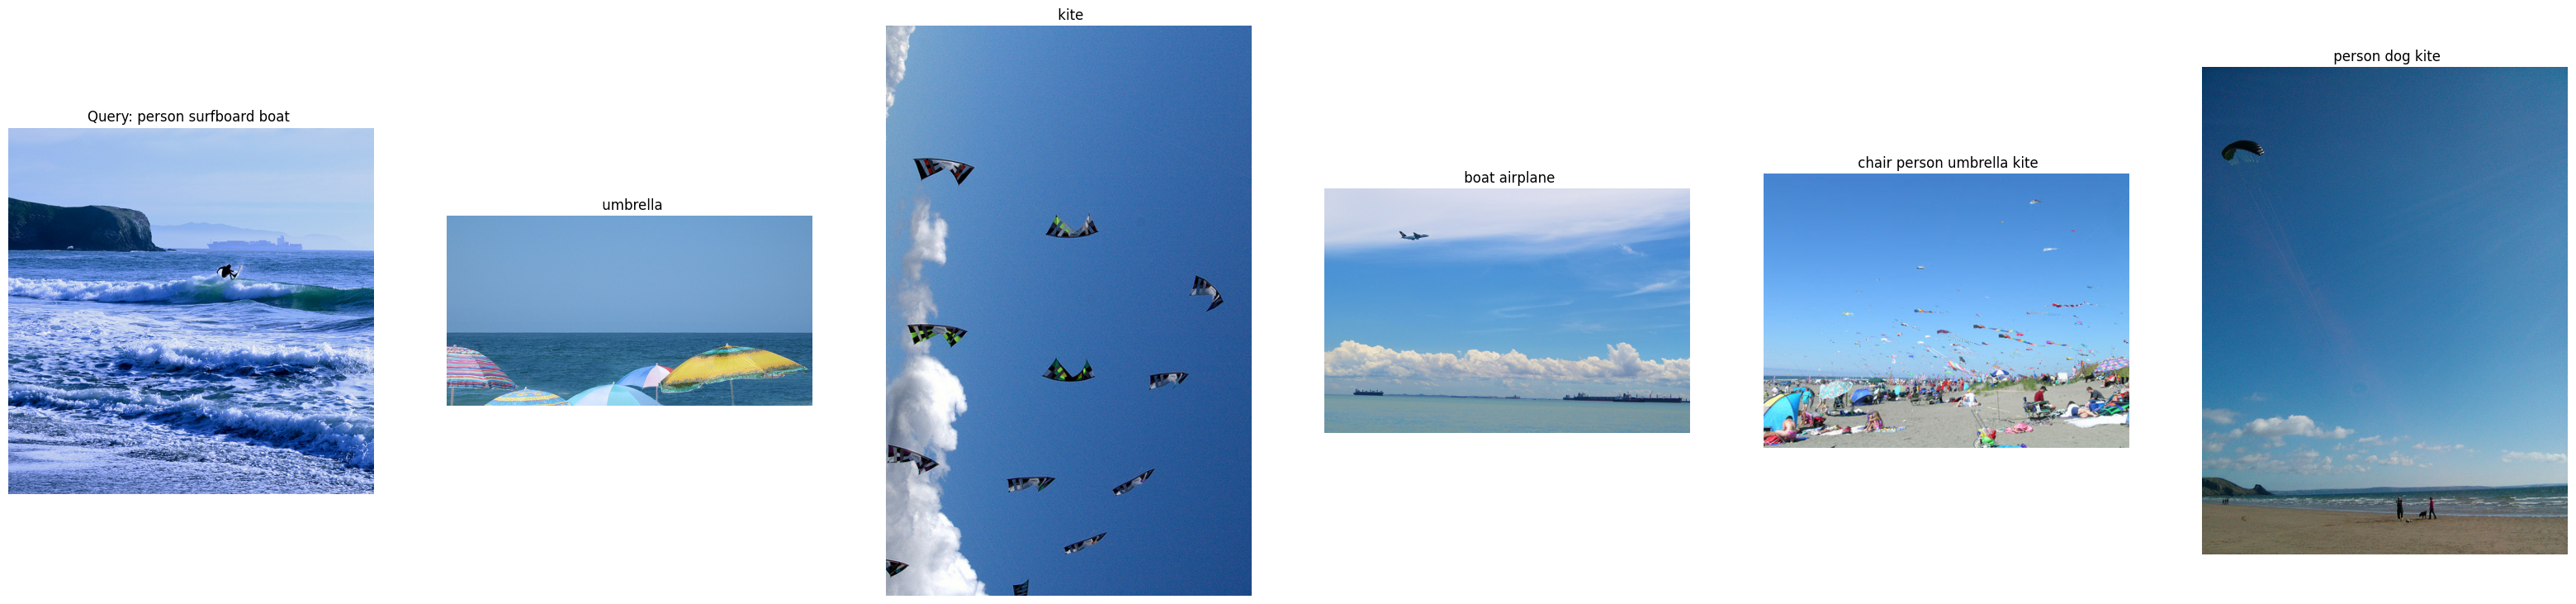

In [114]:
import matplotlib.pyplot as plt
import os

query_number = 8
print(I[0])
retrieved_images = []
retrieved_images_categories = []

classes =  ["", 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
           'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
           'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
           'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
           'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
           'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
           'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
           'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
           'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
           'toothbrush']

for j in range(I[query_number].shape[0]):
        image_database_filename = coco.loadImgs(database_id[I[query_number][j]])[0]["file_name"]
        image_database_annotations = coco.loadAnns(coco.getAnnIds(database_id[I[query_number][j]]))
        image_category = []
        for object in image_database_annotations:
            image_category.append(object["category_id"])
        
        string = ""
        for i in set(image_category):
             string += " " 
             string +=classes[i]
             
        retrieved_images.append(image_database_filename)
        retrieved_images_categories.append(string)

print(retrieved_images)
print(retrieved_images_categories)

image_query_filename = coco_valid.loadImgs(queries_id[query_number])[0]["file_name"]
image_query_annotations = coco_valid.loadAnns(coco_valid.getAnnIds(queries_id[query_number]))
image_query_category = []
for object in image_query_annotations:
     image_query_category.append(object["category_id"])

string = "Query: "
for i in set(image_query_category):
     string += classes[i]
     string += " "
target_size = (200, 200)
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=len(retrieved_images)+1, figsize=(40, 20))
img = plt.imread(os.path.join('./COCO/val2014/', image_query_filename))
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(string)
# Loop through each filename and plot the image
for i, filename in enumerate(retrieved_images):
    img = plt.imread(os.path.join('./COCO/train2014/',filename))
    # Resize the image
    axes[i+1].imshow(img)
    axes[i+1].axis('off')
    axes[i+1].set_title(retrieved_images_categories[i])

# Display the figure
plt.show()